<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indexes/blob/main/Code/XGBoost_Regressor_with_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [2]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from itertools import product
import statsmodels.api as sm
import shap
from IPython.display import display
import math

In [3]:
import warnings
warnings.filterwarnings("ignore")

# **XGBOOST REGRESSOR**

**First, we plot the ACF for every feature to determine the amount of lags needed and the interval between them, since the granularity is 1 sec.**

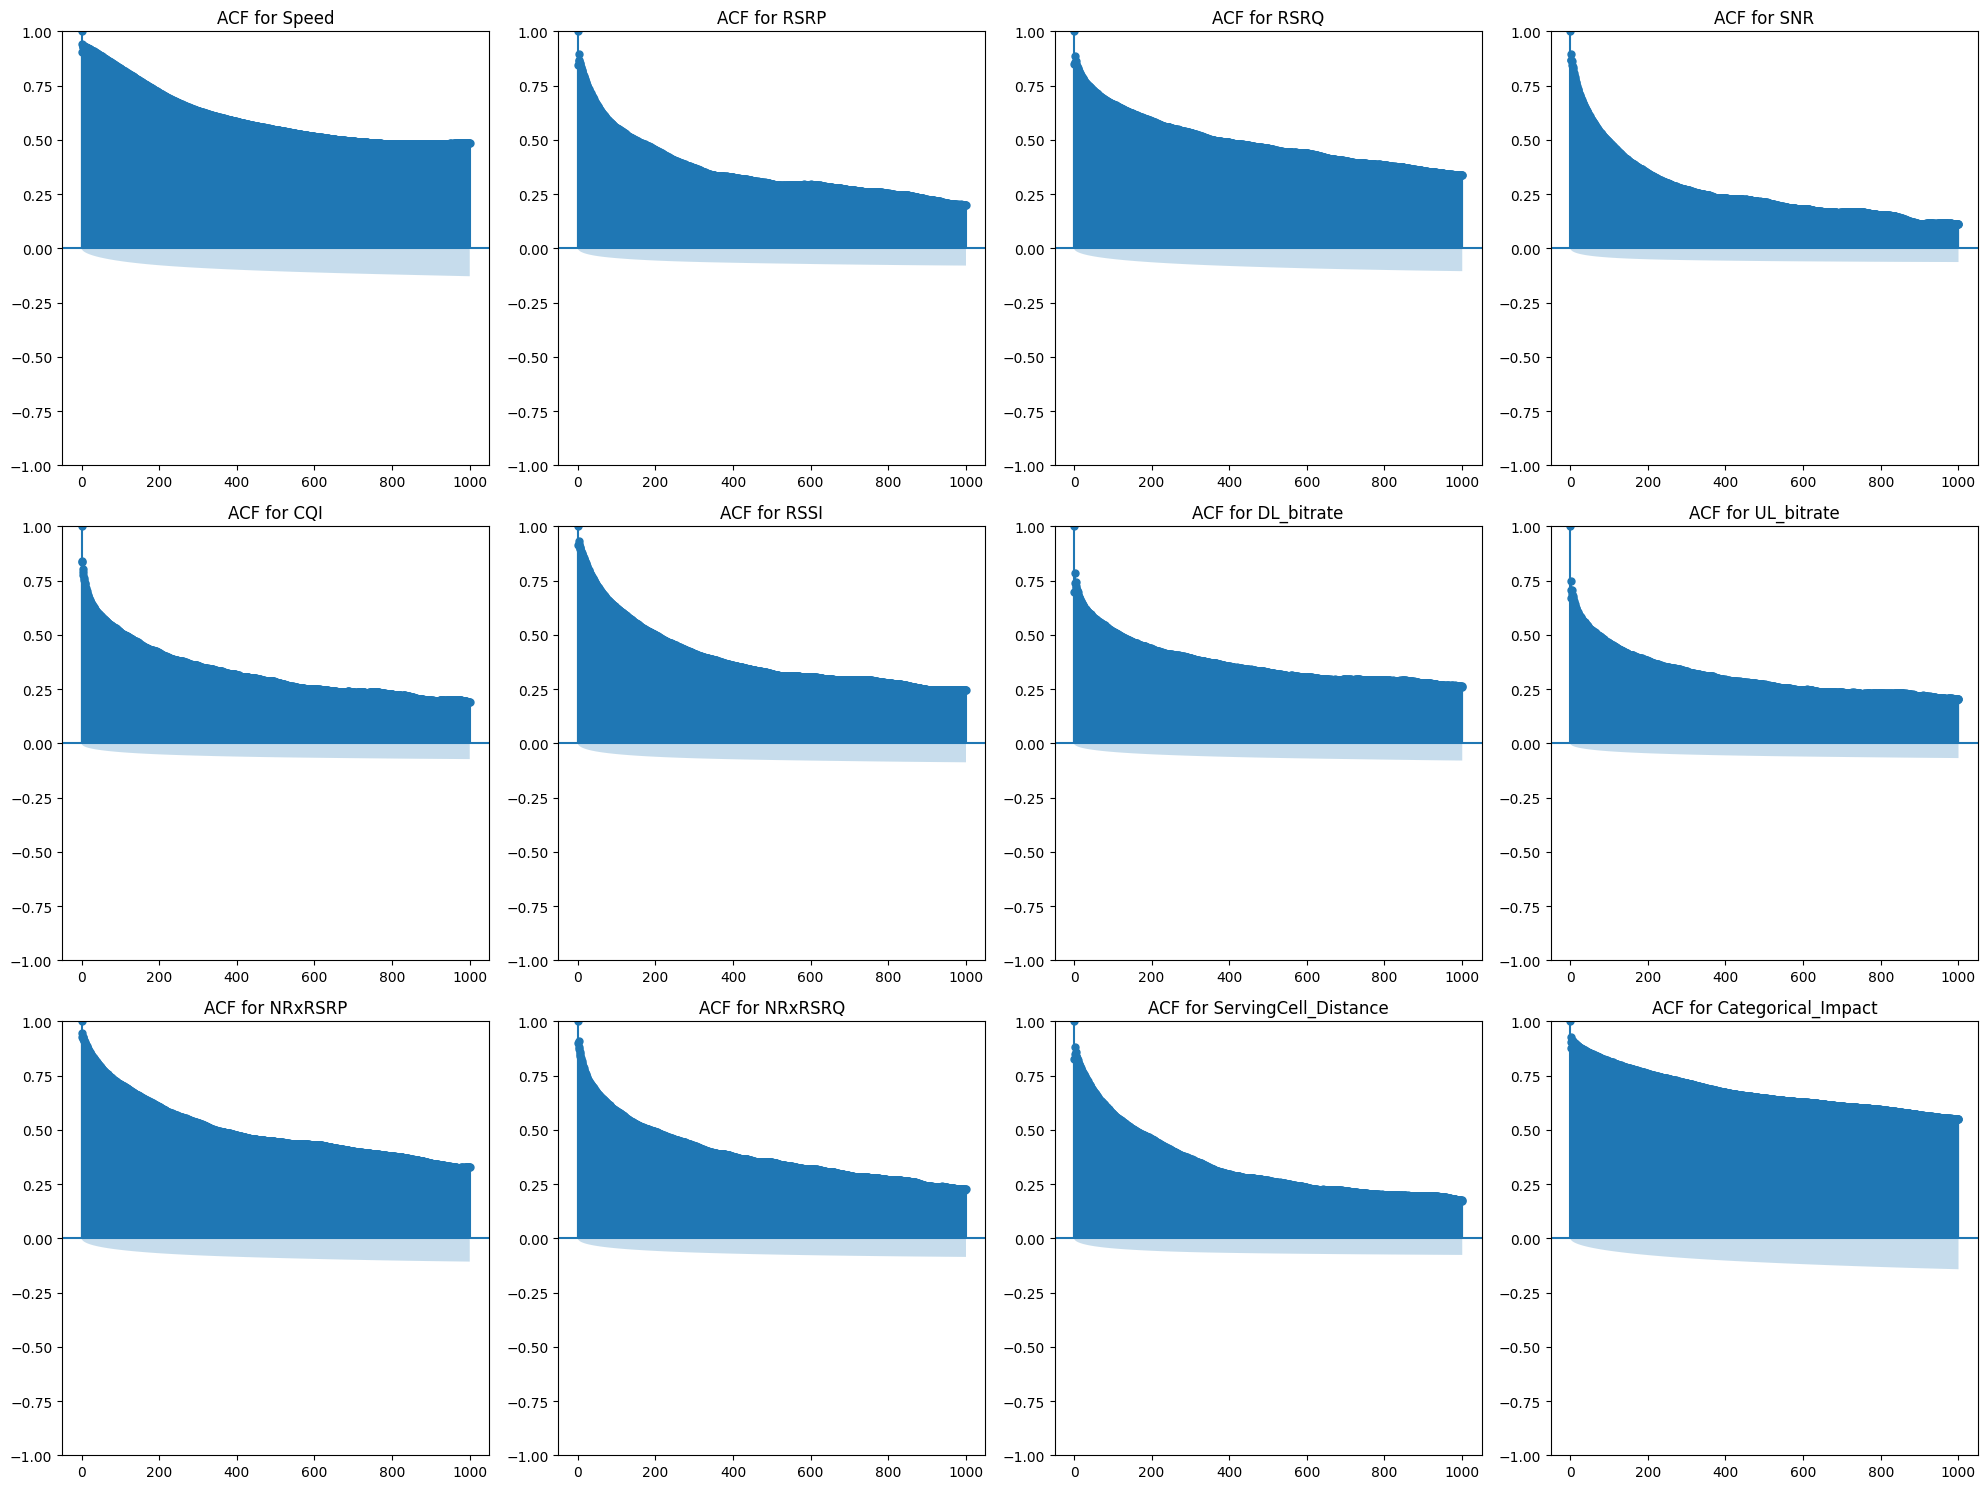

In [4]:
# Φόρτωση του τελικού dataset
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")

# Επιλογή όλων των αριθμητικών στηλών (όπως ορίζονται)
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# Υπολογισμός και σχεδίαση ACF για κάθε αριθμητικό χαρακτηριστικό
rows, cols = 3, 4
num_features = len(features)
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

for i, column in enumerate(features):
    row, col = divmod(i, cols)  # Υπολογισμός θέσης στο grid
    sm.graphics.tsa.plot_acf(df[column].dropna(), lags=1000, alpha=0.05, ax=axes[row, col])
    axes[row, col].set_title(f"ACF for {column}")

plt.tight_layout()
plt.show()

**Then, we apply Grid Search with 5-Cross Validation to determine the best combination of the hyperparameters for the different amount of lagged features based on MAE of Validation Set. We split the Dataset into the following subsets:**

**Training Set: 70%**

**Validation Set: 15%**

**Test Set: 15%**

**We also apply Min-Max Normalization since the numeric features are measured in different units.**

In [ ]:
# --- Δημιουργία lagged χαρακτηριστικών
def create_lagged_features(df, features, num_lags, lag_interval=1):
    df = df.copy()
    for feature in features:
        for lag in range(lag_interval, lag_interval * num_lags + 1, lag_interval):
            df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    return df.dropna()

# --- Ορισμός χαρακτηριστικών
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# --- Παράμετροι
lag_interval = 60
num_lags_list = [5, 10, 20, 30]
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.05, 0.1, 1]
}
param_combinations = list(product(param_grid["n_estimators"],
                                  param_grid["max_depth"],
                                  param_grid["learning_rate"]))

results_list = []

for num_lags in num_lags_list:
    df_lagged = create_lagged_features(df, features, num_lags, lag_interval=lag_interval)

    X = df_lagged.drop(columns=["Timestamp", "DL_bitrate"])
    y = df_lagged["DL_bitrate"]

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

    for n_estimators, max_depth, learning_rate in param_combinations:
        model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            objective="reg:squarederror",
            random_state=42
        )

        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        y_val_pred_denorm = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
        y_val_true = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()

        mae_val = mean_absolute_error(y_val_true, y_val_pred_denorm)

        results_list.append({
            "num_lags": num_lags,
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "MAE_Validation": mae_val
        })

# --- Εύρεση καλύτερου συνδυασμού
results_df = pd.DataFrame(results_list)
best_row = results_df.loc[results_df["MAE_Validation"].idxmin()]

print("\n--- Best Configuration Based on Validation MAE ---")
print(f"Num Lags      : {best_row['num_lags']}")
print(f"n_estimators  : {best_row['n_estimators']}")
print(f"max_depth     : {int(best_row['max_depth'])}")
print(f"learning_rate : {best_row['learning_rate']}")
print(f"Validation MAE: {best_row['MAE_Validation']:.2f}")


--- Best Configuration Based on Validation MAE ---
Num Lags      : 30.0
n_estimators  : 200.0
max_depth     : 3
learning_rate : 0.05
Validation MAE: 876.59


**We train the model using the best combination of lags and hyperparameters and use the test set for the evaluation of the predictions. We also apply Feature Engineering to add rolling window statistic and time based features as input features to boost the performance of the model.**

In [7]:
# --- Δημιουργία lagged χαρακτηριστικών με τα καλύτερα lags
best_num_lags = 30  # Όπως βρήκαμε από τα αποτελέσματα

df_lagged = create_lagged_features(df, features, best_num_lags, lag_interval=60)

# --- Time-based features
df_lagged["Timestamp"] = pd.to_datetime(df_lagged["Timestamp"])
df_lagged["Hour"] = df_lagged["Timestamp"].dt.hour
df_lagged["Day_of_week"] = df_lagged["Timestamp"].dt.dayofweek
df_lagged["Is_weekend"] = df_lagged["Day_of_week"].isin([5, 6]).astype(int)

# --- Rolling mean features (10 και 30 λεπτά)
rolling_features = ['RSRP', 'RSRQ', 'SNR', 'RSSI', 'Speed', 'DL_bitrate', 'UL_bitrate']
for feature in rolling_features:
    for window in [10, 30]:  # λεπτά, επειδή έχουμε sampling κάθε 1 λεπτό
        df_lagged[f"{feature}_roll_mean_{window}"] = df_lagged[feature].rolling(window=window).mean()

# Drop NaNs μετά το rolling
df_lagged.dropna(inplace=True)

# Εφαρμογή log1p σε DL_bitrate, UL_bitrate και rolling τους
apply_log_to = ['DL_bitrate', 'UL_bitrate']
for col in apply_log_to:
    df_lagged[col] = np.log1p(df_lagged[col])

In [8]:
df_lagged

,Timestamp,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,...,SNR_roll_mean_10,SNR_roll_mean_30,RSSI_roll_mean_10,RSSI_roll_mean_30,Speed_roll_mean_10,Speed_roll_mean_30,DL_bitrate_roll_mean_10,DL_bitrate_roll_mean_30,UL_bitrate_roll_mean_10,UL_bitrate_roll_mean_30
1829,2017-11-21 15:40:02,3.0,-76.0,-13.0,12.0,8.0,-58.0,7.312553,3.951244,-79.0,...,11.6,1.533333,-58.80,-58.866667,0.9,2.200000,5121.80,3856.800000,109.40,80.666667
1830,2017-11-21 15:40:04,3.0,-74.0,-13.0,10.0,8.0,-58.0,8.192294,4.543295,-85.0,...,12.3,1.966667,-58.90,-58.833333,1.2,2.200000,4701.30,3957.100000,104.40,83.400000
1831,2017-11-21 15:40:05,3.0,-74.0,-13.0,10.0,8.0,-58.0,8.539346,4.564348,-85.0,...,12.0,2.400000,-58.80,-58.800000,1.5,2.200000,5019.00,4107.366667,109.10,86.200000
1832,2017-11-21 15:40:06,3.0,-77.0,-13.0,15.0,11.0,-60.0,7.377759,3.401197,-85.0,...,12.2,3.000000,-58.70,-58.833333,1.8,2.200000,4552.60,4124.533333,100.40,86.366667
1833,2017-11-21 15:40:07,4.0,-77.0,-13.0,15.0,11.0,-60.0,7.377759,3.401197,-85.0,...,12.5,3.700000,-58.90,-58.866667,2.2,2.233333,4001.20,4117.466667,85.20,85.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173687,2018-02-12 16:28:41,0.0,-104.0,-11.0,13.0,10.0,-83.0,10.462346,6.430526,-90.0,...,8.4,11.400000,-83.55,-78.516667,0.0,0.000000,16188.60,18818.750000,286.30,337.050000
173688,2018-02-12 16:28:42,0.0,-106.0,-13.0,3.0,7.0,-90.0,8.411166,4.382027,-90.0,...,8.0,10.900000,-84.95,-78.983333,0.0,0.000000,15989.60,17802.866667,283.80,319.033333
173689,2018-02-12 16:28:42,0.0,-104.0,-11.0,13.0,10.0,-83.0,10.462346,6.430526,-90.0,...,7.6,11.100000,-85.45,-79.216667,0.0,0.000000,15989.60,18911.983333,283.80,338.650000
173690,2018-02-12 16:28:43,0.0,-100.0,-12.0,16.0,13.0,-81.0,10.462346,6.430526,-90.0,...,8.5,11.033333,-85.95,-79.383333,0.0,0.000000,19218.45,18911.983333,340.55,338.650000


**To check if the model is over or under fitting we plot the learning curves for the training, validation and testing set.**

[0]	train-rmse:0.29116	train-mae:0.21476	eval-rmse:0.20874	eval-mae:0.18352	test-rmse:0.23299	test-mae:0.17332
[10]	train-rmse:0.17933	train-mae:0.13324	eval-rmse:0.13520	eval-mae:0.11914	test-rmse:0.14856	test-mae:0.10987
[20]	train-rmse:0.11300	train-mae:0.08524	eval-rmse:0.09026	eval-mae:0.07936	test-rmse:0.09996	test-mae:0.07323
[30]	train-rmse:0.07474	train-mae:0.05705	eval-rmse:0.06355	eval-mae:0.05457	test-rmse:0.07456	test-mae:0.05274
[40]	train-rmse:0.05370	train-mae:0.04066	eval-rmse:0.04849	eval-mae:0.03990	test-rmse:0.06204	test-mae:0.04151
[50]	train-rmse:0.04311	train-mae:0.03135	eval-rmse:0.04044	eval-mae:0.03154	test-rmse:0.05633	test-mae:0.03551
[60]	train-rmse:0.03819	train-mae:0.02616	eval-rmse:0.03608	eval-mae:0.02686	test-rmse:0.05381	test-mae:0.03245
[70]	train-rmse:0.03598	train-mae:0.02323	eval-rmse:0.03370	eval-mae:0.02416	test-rmse:0.05255	test-mae:0.03071
[80]	train-rmse:0.03496	train-mae:0.02153	eval-rmse:0.03238	eval-mae:0.02256	test-rmse:0.05190	test-mae:0

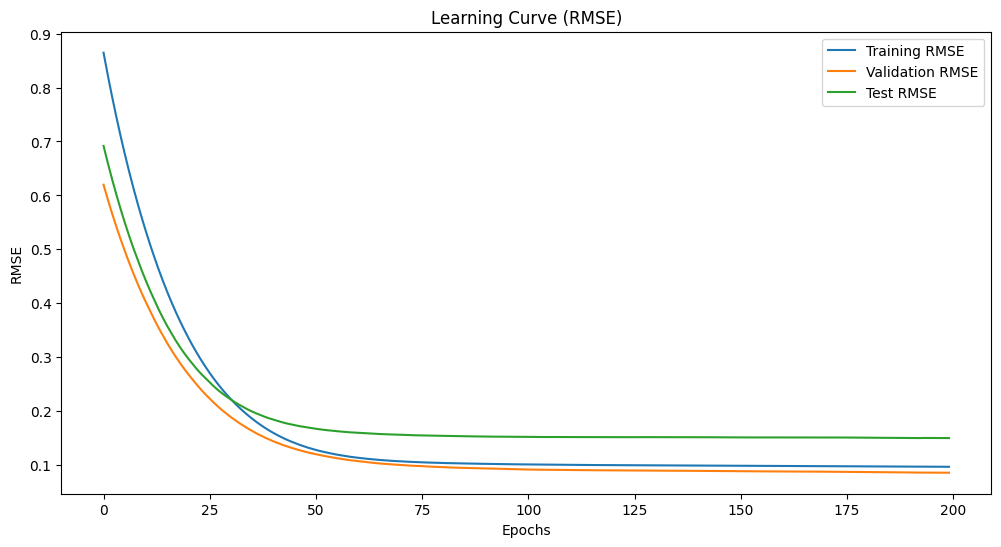

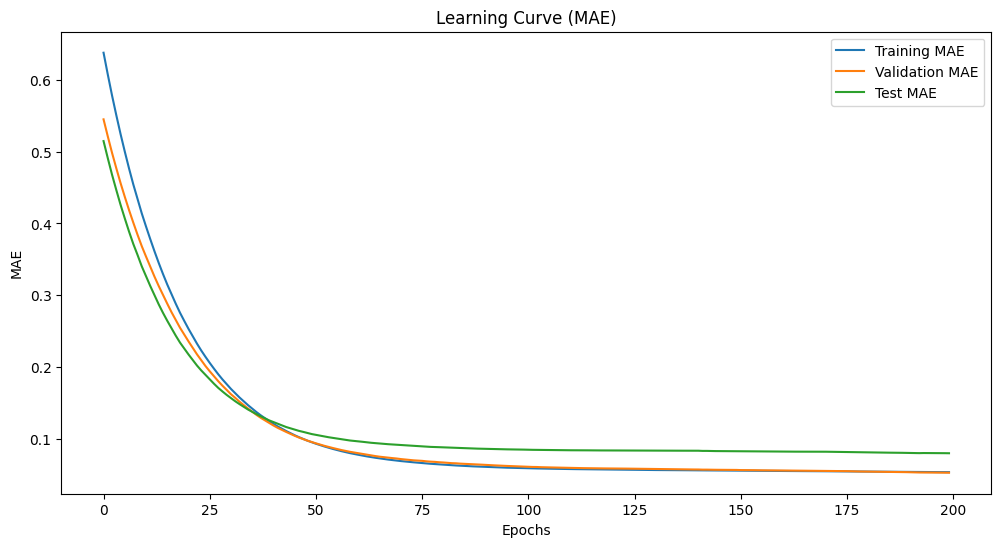

----------------------------------------
Train RMSE: 1919.05
Train MAE : 1037.29
----------------------------------------
Validation RMSE: 3793.78
Validation MAE : 2324.01
----------------------------------------
Test RMSE: 2735.95
Test MAE : 1542.21


In [9]:
# --- Διαχωρισμός χαρακτηριστικών και στόχου
X = df_lagged.drop(columns=["Timestamp", "DL_bitrate", "Predicted_DL_bitrate"], errors="ignore")
y = df_lagged["DL_bitrate"]

# --- Κανονικοποίηση
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# --- Διαχωρισμός σε train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# --- Δημιουργία DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# --- Υπερπαράμετροι
params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'eval_metric': ['rmse', 'mae']
}

evals = [(dtrain, 'train'), (dval, 'eval'), (dtest, 'test')]
num_round = 200
history = dict()

# --- Εκπαίδευση
bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10, verbose_eval=10, evals_result=history)

# --- Learning curves
epochs = len(history['train']['rmse'])
train_rmse = np.array(history['train']['rmse']) * np.std(y)
eval_rmse = np.array(history['eval']['rmse']) * np.std(y)
test_rmse = np.array(history['test']['rmse']) * np.std(y)

train_mae = np.array(history['train']['mae']) * np.std(y)
eval_mae = np.array(history['eval']['mae']) * np.std(y)
test_mae = np.array(history['test']['mae']) * np.std(y)

plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_rmse, label="Training RMSE")
plt.plot(range(epochs), eval_rmse, label="Validation RMSE")
plt.plot(range(epochs), test_rmse, label="Test RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Learning Curve (RMSE)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_mae, label="Training MAE")
plt.plot(range(epochs), eval_mae, label="Validation MAE")
plt.plot(range(epochs), test_mae, label="Test MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Learning Curve (MAE)")
plt.legend()
plt.show()

# --- Προβλέψεις και αποθήκευση σε ξεχωριστό DataFrame
predictions_df = pd.DataFrame()

# Train set
y_train_pred = bst.predict(dtrain)
y_train_pred_denorm = np.expm1(scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten())
y_train_true = np.expm1(scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten())

train_df = pd.DataFrame({
    "true": y_train_true,
    "pred": y_train_pred_denorm,
    "set": "train"
})

# Validation set
y_val_pred = bst.predict(dval)
y_val_pred_denorm = np.expm1(scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten())
y_val_true = np.expm1(scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten())

val_df = pd.DataFrame({
    "true": y_val_true,
    "pred": y_val_pred_denorm,
    "set": "val"
})

# Test set
y_test_pred = bst.predict(dtest)
y_test_pred_denorm = np.expm1(scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten())
y_test_true = np.expm1(scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten())

test_df = pd.DataFrame({
    "true": y_test_true,
    "pred": y_test_pred_denorm,
    "set": "test"
})

# --- Συνένωση όλων των προβλέψεων
predictions_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# --- Υπολογισμός και εκτύπωση μετρικών
def print_metrics(name, true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print("-" * 40)
    print(f"{name} RMSE: {rmse:.2f}")
    print(f"{name} MAE : {mae:.2f}")

print_metrics("Train", y_train_true, y_train_pred_denorm)
print_metrics("Validation", y_val_true, y_val_pred_denorm)
print_metrics("Test", y_test_true, y_test_pred_denorm)

**We calculate for better understanding the percentages of the error metrics to see how far the predictions are from the average actual DL_bitrate of the test data.**

In [11]:
# Φιλτράρισμα test set από το predictions_df
test_data = predictions_df[predictions_df["set"] == "test"]

# Υπολογισμός μέσης πραγματικής τιμής
mean_actual_value = test_data["true"].mean()

# Υπολογισμός MAE & RMSE από το predictions_df
test_rmse = np.sqrt(mean_squared_error(test_data["true"], test_data["pred"]))
test_mae = mean_absolute_error(test_data["true"], test_data["pred"])

# Εκτύπωση ποσοστών σφάλματος ως προς τη μέση τιμή
print(f"Percentage of MAE: {(test_mae / mean_actual_value) * 100:.2f}%")
print(f"Percentage of RMSE: {(test_rmse / mean_actual_value) * 100:.2f}%")

Percentage of MAE: 16.97%
Percentage of RMSE: 30.11%


**After the evaluation of the model we plot the actual and the predicted timeseries to visualize the forecasting results.**

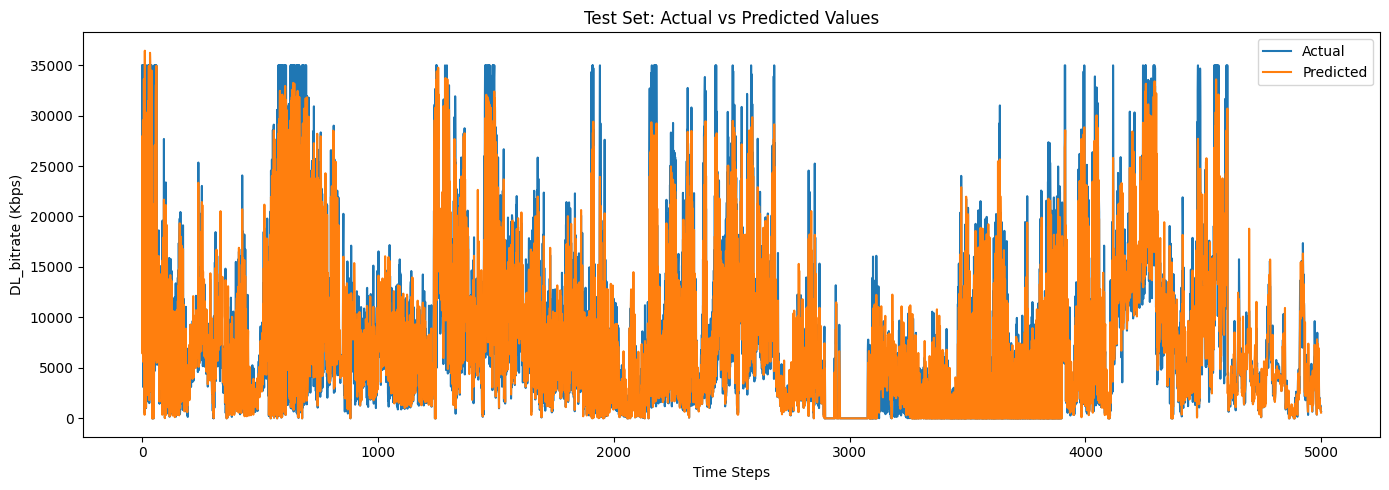

In [13]:
# === Χρονοσειρά Actual vs Predicted (Test Set)
plt.figure(figsize=(14, 5))
plt.plot(test_df["true"].values[:5000], label='Actual')
plt.plot(test_df["pred"].values[:5000], label='Predicted')
plt.title("Test Set: Actual vs Predicted Values")
plt.xlabel("Time Steps")
plt.ylabel("DL_bitrate (Kbps)")
plt.legend()
plt.tight_layout()
plt.show()

**Finally, we use the SHAP tool to determine which features contribute the most into the final forecasting value. We compute a Waterfall Plot to check the feature contribution in one instance and then we compute Bar Plot and Beeswarm Plot to determine the overall contribution.**

100%|===================| 25653/25780 [01:15<00:00]       

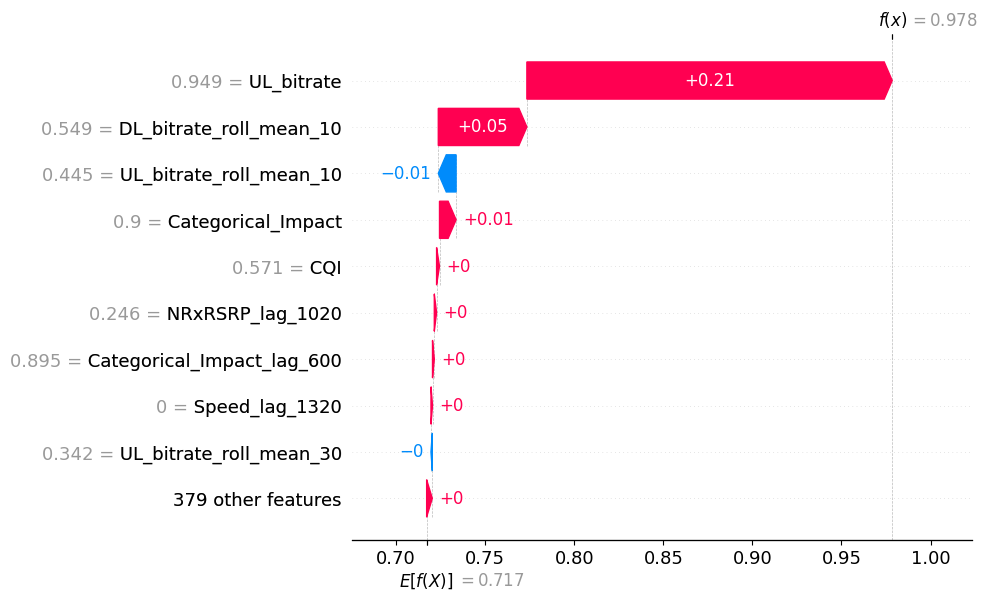

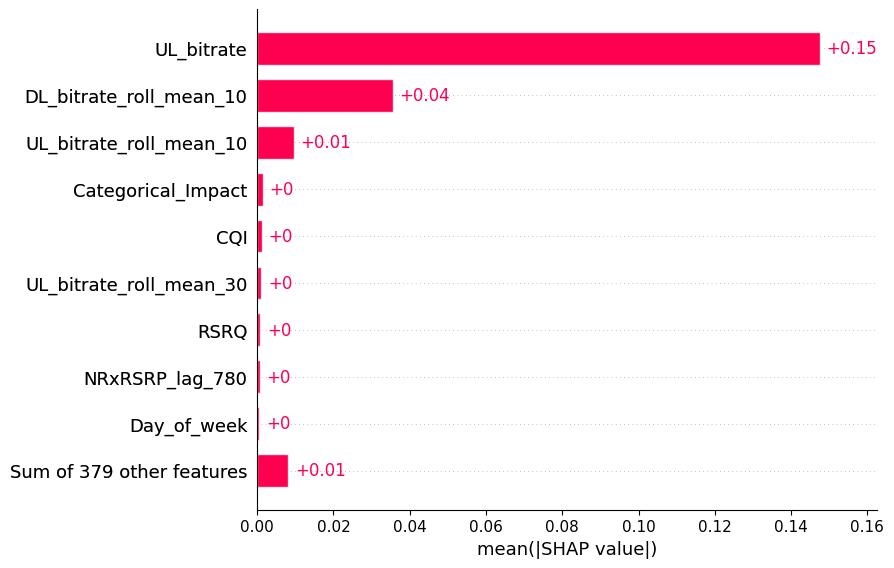

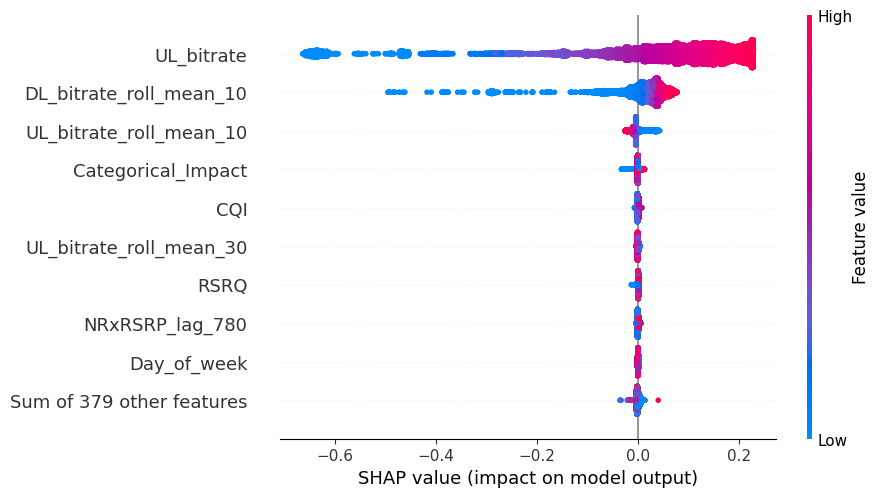

In [14]:
X_test_df = pd.DataFrame(X_test, columns=X.columns)

shap.initjs()

# Δημιουργία Explainer και υπολογισμός SHAP values
explainer = shap.Explainer(bst, X_test_df)
shap_values = explainer(X_test_df)

# Waterfall plot
shap.plots.waterfall(shap_values[0])

#Bar plot
shap.plots.bar(shap_values)

#Beeswarm plot
shap.plots.beeswarm(shap_values)

100%|===================| 25678/25780 [01:54<00:00]       

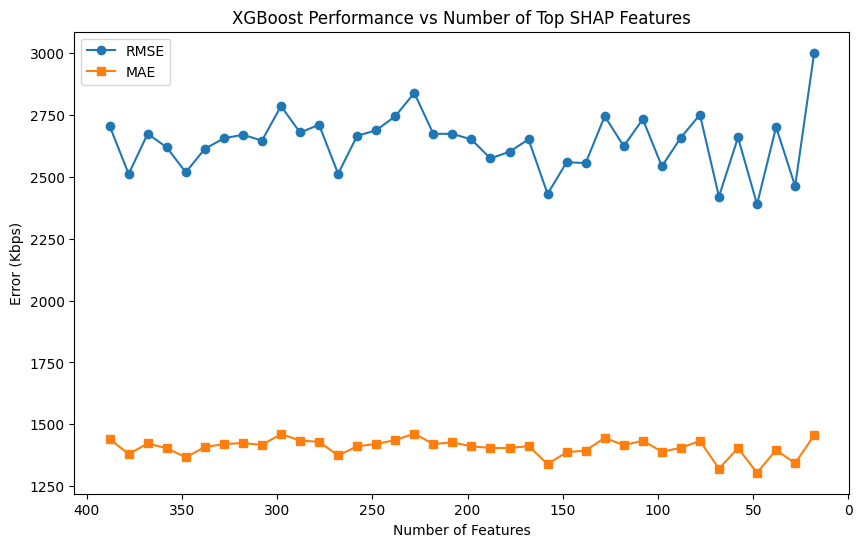

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# === Προετοιμασία χαρακτηριστικών και στόχου
target = df_lagged["DL_bitrate"]
X = df_lagged.drop(columns=["Timestamp", "DL_bitrate"], errors="ignore")
X_feature_columns = X.columns  # αποθήκευση για SHAP

# === Κανονικοποίηση
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# === Split σε train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=False, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False, random_state=42)

# === Εκπαίδευση μοντέλου για SHAP
bst = xgb.train(
    params={
        "objective": "reg:squarederror",
        "max_depth": 5,
        "learning_rate": 0.1,
        "n_estimators": 200,
        "eval_metric": "rmse"
    },
    dtrain=xgb.DMatrix(X_train, label=y_train),
    num_boost_round=200
)

# === Υπολογισμός SHAP values σε αποκανονικοποιημένα χαρακτηριστικά
X_test_df = pd.DataFrame(scaler_X.inverse_transform(X_test), columns=X_feature_columns)
explainer = shap.Explainer(bst, X_test_df)
shap_values = explainer(X_test_df)

# === Υπολογισμός μέσης σημασίας και ταξινόμηση
shap_df = pd.DataFrame(shap_values.values, columns=X_feature_columns)
shap_mean = shap_df.abs().mean().sort_values(ascending=False)
ordered_features = shap_mean.index.tolist()

# === Επανεκπαίδευση με top-N χαρακτηριστικά
results = []
step = 10
for num_features in range(len(ordered_features), step - 1, -step):
    selected_feats = [f for f in ordered_features[:num_features] if f in df_lagged.columns]
    X_subset = df_lagged[selected_feats]
    y = df_lagged["DL_bitrate"]

    # Κανονικοποίηση
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_subset)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    # Split
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=False, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False, random_state=42)

    # Εκπαίδευση
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        objective="reg:squarederror",
        random_state=42
    )
    model.fit(X_train, y_train)

    # Προβλέψεις και αποκανονικοποίηση
    y_pred = model.predict(X_test)
    y_pred_denorm = np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten())
    y_test_denorm = np.expm1(scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten())

    # Μετρικές
    rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)

    results.append({
        "Num_Features": num_features,
        "RMSE": rmse,
        "MAE": mae
    })

# === Αποτελέσματα & Οπτικοποίηση
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df["Num_Features"], results_df["RMSE"], marker='o', label="RMSE")
plt.plot(results_df["Num_Features"], results_df["MAE"], marker='s', label="MAE")
plt.xlabel("Number of Features")
plt.ylabel("Error (Kbps)")
plt.title("XGBoost Performance vs Number of Top SHAP Features")
plt.legend()
plt.gca().invert_xaxis()
plt.show()